<a href="https://colab.research.google.com/github/Jaime44/WorkSpace/blob/main/models/rnn_rs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import sys

# Comprueba si el código se está ejecutando en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    print("El código se está ejecutando en Google Colab.")
    from google.colab import drive
    import tensorflow as tf

    drive.mount('/content/drive')
    path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/Models/neural network'


    # Cambia al directorio de tu carpeta en Google Drive
    os.chdir(path_absolute)

    # Lista los archivos y carpetas en el directorio actual
    contenido_carpeta = os.listdir(path_absolute)
    print("Contenido de la carpeta en Google Drive:")
    print(contenido_carpeta)

    # Verificar la GPU
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU no encontrada')
    print(f'Encontrada GPU: {device_name}')

    # Habilitar la GPU para TensorFlow
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print('Memoria de la GPU configurada dinámicamente')
    else:
        print('No se encontraron dispositivos GPU configurables')


else:
    print("El código se está ejecutando en un entorno local.")
    path_absolute = os.getcwd().replace("\\", "/")
    path_absolute = 'C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/'

datasets_path = "/datasets/"
path_absolute = path_absolute+datasets_path

El código se está ejecutando en un entorno local.


In [6]:
path_workspace ='C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/'
sys.path.append(path_workspace)

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import Utils.utils as util


from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate


# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset


In [14]:
# dataFrame = pd.read_csv(path_absolute+'df_movies_rating.csv', sep=',')
# dataFrame.head()
# df_movies_rating.csv con el tag condificado a valor unico
dataFrame = pd.read_csv(path_absolute+'df_movies_rating_2.csv', sep=',')
data = dataFrame.copy()

In [15]:
data.head()

,userId,movieId,timestamp_scr,tag,tag_encoded,timestamp_tags,title,(no genres listed),Action,Adventure,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,3,260,1439472239,classic,0,1439472355,Star Wars: Episode IV - A New Hope (1977),0,1,1,...,0,0,0,0,0,1,0,0,0,4.0
1,3,260,1439472239,sci-fi,1,1439472256,Star Wars: Episode IV - A New Hope (1977),0,1,1,...,0,0,0,0,0,1,0,0,0,4.0
2,264,260,1543390081,aliens,2,1543390134,Star Wars: Episode IV - A New Hope (1977),0,1,1,...,0,0,0,0,0,1,0,0,0,3.0
3,264,260,1543390081,oldie but goodie,3,1543390130,Star Wars: Episode IV - A New Hope (1977),0,1,1,...,0,0,0,0,0,1,0,0,0,3.0
4,264,260,1543390081,scifi cult,4,1543390105,Star Wars: Episode IV - A New Hope (1977),0,1,1,...,0,0,0,0,0,1,0,0,0,3.0


In [16]:
if IN_COLAB:
    tamano_muestra = data.shape[0] #834.730
else:
    # Especifica el tamaño de la muestra que deseas obtener
    tamano_muestra = 10000

In [26]:
# Obtiene una muestra aleatoria uniforme del DataFrame
data = data.sample(n=tamano_muestra, random_state=42)  # random_state para reproducibilidad
data.shape

(10000, 23)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 550126 to 347734
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   userId              10000 non-null  int64  
 1   movieId             10000 non-null  int64  
 2   timestamp_scr       10000 non-null  int64  
 3   tag                 10000 non-null  object 
 4   tag_encoded         10000 non-null  int64  
 5   timestamp_tags      10000 non-null  int64  
 6   title               10000 non-null  object 
 7   (no genres listed)  10000 non-null  int64  
 8   Action              10000 non-null  int64  
 9   Adventure           10000 non-null  int64  
 10  Animation           10000 non-null  int64  
 11  Children            10000 non-null  int64  
 12  Comedy              10000 non-null  int64  
 13  Crime               10000 non-null  int64  
 14  Documentary         10000 non-null  int64  
 15  Drama               10000 non-null  int64  
 16

Quito las calumnas categoricas de título y tag ambas estan represnetadas en las columnas númericas de tag_encode e id movie.

In [19]:
# util.contar_ocurrencias(data, '(no genres listed)')
# util.mostrar_filas_por_valor(data, '(no genres listed)', 1)

Total de clases(Puntuaciones) a predecir

In [20]:
data = util.eliminar_columnas(data, ['tag', 'title', '(no genres listed)'])
util.contar_ocurrencias(data, 'rating')

Valor: 4.0, Frecuencia: 2226
Valor: 5.0, Frecuencia: 2127
Valor: 3.5, Frecuencia: 1584
Valor: 4.5, Frecuencia: 1564
Valor: 3.0, Frecuencia: 1078
Valor: 2.5, Frecuencia: 510
Valor: 2.0, Frecuencia: 397
Valor: 1.5, Frecuencia: 188
Valor: 1.0, Frecuencia: 186
Valor: 0.5, Frecuencia: 140
Total de valores distintos: 10


In [21]:
data = util.eliminar_columnas(data, ['timestamp_tags', 'timestamp_scr'])

In [22]:
data.head()

,userId,movieId,tag_encoded,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
550126,64333,42197,31405,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1.5
722840,15078,3993,2699,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5.0
606031,141263,5459,9448,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1.0
49993,133400,134130,4293,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,5.0
122599,18057,4226,1582,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,5.0


# MODELO CON KERAS

In [23]:
# # Dividir datos en entrenamiento y prueba
# train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# train_data_scaled = train_data.drop("rating", axis=1)
# test_data_scaled = test_data.drop("rating", axis=1)
# num_features = len(train_data.columns) - 1

# # Normalizar datos
# scaler = StandardScaler()
# train_data_scaled = scaler.fit_transform(train_data_scaled)
# test_data_scaled = scaler.transform(test_data_scaled)

# # Construir el modelo de recomendación sin escalado
# model = Sequential()

# # Capas de entrada para datos numéricos
# model.add(Dense(128, activation='relu', input_shape=(num_features,)))
# model.add(Dense(128, activation='relu',kernel_initializer='random_normal', bias_initializer='random_normal'))
# model.add(Dense(128, activation='relu',kernel_initializer='random_normal', bias_initializer='random_normal'))  # Nueva capa
# model.add(Dense(128, activation='relu',kernel_initializer='random_normal', bias_initializer='random_normal'))  # Otra nueva capa
# model.add(Dense(128, activation='relu',kernel_initializer='random_normal', bias_initializer='random_normal'))
# model.add(Dense(128, activation='relu',kernel_initializer='random_normal', bias_initializer='random_normal'))

# # Capa de salida para predicción de puntuación
# model.add(Dense(1, activation='linear'))

# # Compilar el modelo
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error', 'accuracy'])

# # Entrenar el modelo
# history = model.fit(train_data_scaled, train_data['rating'], epochs=100, batch_size=256, validation_split=0.2, verbose=0)

# # Evaluar el modelo en el conjunto de prueba
# loss, mae, accuracy = model.evaluate(test_data_scaled, test_data['rating'])
# print(f'Mean Absolute Error on Test Data: {mae}')


# # Realizar predicciones
# predictions = model.predict(test_data_scaled)

# util.plot_loss(history)
# util.plot_accuracy(history)

    GRÁFICA DE DISPERSIÓN

In [24]:

# # Realizar predicciones en el conjunto de prueba
# predictions = model.predict(test_data_scaled)

# # Obtener las puntuaciones reales y predicciones en una escala común (por ejemplo, de 0 a 5)
# y_true = test_data['rating'].values
# y_pred = predictions.flatten()  # Utilizamos flatten para convertir la matriz en un array unidimensional

# y_pred_round2 = np.clip(predictions.flatten(), 0.5, 5)  # Limitar los valores entre 0.5 y 5
# y_pred_round2 = np.round(y_pred_round2 * 2) / 2  # Redondear a 0.5
# y_pred = y_pred_round2

# y_pred = [round(val[0], 1) for val in predictions]
# # util.contar_ocurrencias_array(predictions_formatted)

# # Scatter plot de los valores reales frente a los valores predichos
# plt.scatter(y_true, y_pred, color='blue', alpha=0.5)
# plt.plot([0.5, 5], [0.5, 5], linestyle='-', color='red', linewidth=2)  # Línea de 45 grados para referencia

# # Personalización del gráfico
# plt.title('Predicciones vs. Valores Reales')
# plt.xlabel('Valores Reales')
# plt.ylabel('Valores Predichos')
# plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
# plt.yticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
# plt.grid(True)

# # Mostrar el gráfico
# plt.show()

# # Crear un diagrama de dispersión con colores
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=y_true, y=y_pred, color='red', label='Predicciones')
# sns.scatterplot(x=y_true, y=y_true, color='green', label='Puntuaciones Reales')  # La línea diagonal de las puntuaciones reales
# plt.title('Diagrama de Dispersión: Puntuaciones Reales vs. Predicciones')
# plt.xlabel('Puntuaciones Reales')
# plt.ylabel('Predicciones del Modelo')
# plt.legend()
# plt.show()

# # Calcular el error cuadrático medio (MSE)
# mse = mean_squared_error(y_true, y_pred)
# print(f'Mean Squared Error (MSE): {mse}')

# MODELO CON KERAS CON PROCENTAJES

Cambios clave en este código:

- Número de Clases: La capa de salida ahora tiene un número de nodos igual al número de clases únicas en las valoraciones. Esto se determina mediante num_classes.

- Activación Softmax: La capa de salida utiliza la función de activación softmax, que asigna una probabilidad a cada clase y garantiza que la suma de las probabilidades sea igual a 1.

- Loss Function: El modelo utiliza la pérdida categorical_crossentropy porque estamos tratando con múltiples clases.

- One-Hot Encoding: Convertimos las etiquetas de las valoraciones a formato one-hot encoding para adaptarse al formato de salida de la red neuronal.

Después de entrenar el modelo, las predicciones (predictions_proba) serán matrices de probabilidad para cada clase. Puedes interpretar la probabilidad más alta como la predicción de la valoración que el modelo considera más probable para cada ejemplo.

In [25]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# # Convertir las etiquetas a formato one-hot encoding
# y_train_onehot = pd.get_dummies(train_data['rating'])
# y_test_onehot = pd.get_dummies(test_data['rating'])

# # Asegurarse de que las columnas en y_train_onehot y y_test_onehot coincidan
# # Esto es necesario porque puede haber algunas clases ausentes en el conjunto de prueba
# y_test_onehot = y_test_onehot.reindex(columns=y_train_onehot.columns, fill_value=0)

train_data_scaled = train_data.drop("rating", axis=1)
test_data_scaled = test_data.drop("rating", axis=1)
num_features = len(train_data.columns) - 1

# Normalizar datos
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data_scaled)
test_data_scaled = scaler.transform(test_data_scaled)

X_train = train_data_scaled
X_test = test_data_scaled
Y_train =  train_data["rating"]
Y_test = test_data["rating"]

num_classes = Y_test.nunique()

# Construir el modelo de recomendación con predicción de probabilidad
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(num_features,)))
model.add(Dense(64, activation='relu', input_shape=(num_features,)))
model.add(Dense(64, activation='relu', input_shape=(num_features,)))
model.add(Dense(32, activation='relu', input_shape=(num_features,)))
model.add(Dense(num_classes, activation='softmax'))


# Ajustar el learning rate al optimizador Adam
learning_rate = 0.01  # Puedes ajustar este valor según sea necesario
optimizer = Adam(learning_rate=learning_rate)


model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Entrenar el modelo
history_perc = model.fit(X_train, Y_train, epochs=500, batch_size=256, validation_data=(X_test, Y_test))

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Accuracy on Test Data: {accuracy}')

# Realizar predicciones de probabilidad
predictions_proba = model.predict(X_test)

util.plot_loss(history_perc)
util.plot_accuracy(history_perc)


Epoch 1/500
32/32 [==============================] - 2s 26ms/step - loss: 1.5370 - accuracy: 0.2026 - val_loss: 1.4543 - val_accuracy: 0.1800
Epoch 2/500
32/32 [==============================] - 0s 7ms/step - loss: 1.4250 - accuracy: 0.2120 - val_loss: 1.4235 - val_accuracy: 0.2285
Epoch 3/500
32/32 [==============================] - 0s 6ms/step - loss: 1.4137 - accuracy: 0.2173 - val_loss: 1.4255 - val_accuracy: 0.2025
Epoch 4/500
32/32 [==============================] - 0s 7ms/step - loss: 1.4048 - accuracy: 0.2224 - val_loss: 1.4611 - val_accuracy: 0.2255
Epoch 5/500
32/32 [==============================] - 0s 7ms/step - loss: 1.3995 - accuracy: 0.2276 - val_loss: 1.4237 - val_accuracy: 0.2305
Epoch 6/500
32/32 [==============================] - 0s 6ms/step - loss: 1.3933 - accuracy: 0.2230 - val_loss: 1.4229 - val_accuracy: 0.2210
Epoch 7/500
15/32 [=============>................] - ETA: 0s - loss: 1.3927 - accuracy: 0.2365

KeyboardInterrupt: 

In [ ]:
# indx_predicition = 20

rating = [0.5,1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
predicciones_correctas = 0
for indx in range(len(Y_test)):
    max_index = np.argmax(predictions_proba[indx]) + 1
    max_value = predictions_proba[indx][max_index]

    if rating[max_index] == Y_test.values[indx]:
        predicciones_correctas = predicciones_correctas + 1

    # print(f"Vector: {predictions_proba[0]}")
    # print(f"El mayor elemento del vector es: {max_value}")
    # print(f"El índice del mayor elemento es: {max_index} --> RATING: {rating[max_index]}")
    # print(f"El VALOR ESPERADO ES: {Y_test.values[indx]}")

print(f"Total de predicciones: {indx}")
print(f"Total de correctas: {predicciones_correctas}")
print(f"Accuracy: {(predicciones_correctas/indx) * 100}%")

Total de predicciones: 166945
Total de correctas: 15389
Accuracy: 9.218005930096739%


In [ ]:
# Supongamos que 'rating' es tu array de calificaciones
rating = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])

# Obtener el índice del máximo en cada fila
indices_maximos = np.argmax(predictions_proba, axis=1)

# Obtener las calificaciones predichas
calificaciones_predichas = rating[indices_maximos+1]

    GRÁFICA DE DISPERSIÓN

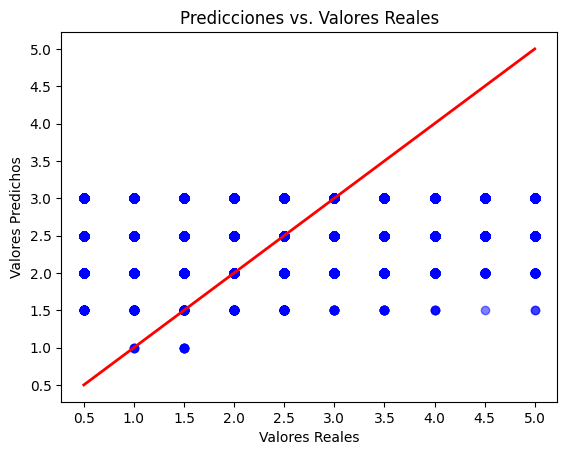

In [ ]:
# Scatter plot de los valores reales frente a los valores predichos
plt.scatter(Y_test.values, calificaciones_predichas, color='blue', alpha=0.5)
plt.plot([0.5, 5], [0.5, 5], linestyle='-', color='red', linewidth=2)  # Línea de 45 grados para referencia

# Personalización del gráfico
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.yticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])

# Mostrar el gráfico
plt.show()

    KERAS SIMPLIFICADO

In [ ]:
# # Dividir datos en entrenamiento y prueba
# train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# # Normalizar datos
# scaler = StandardScaler()
# train_data_scaled = scaler.fit_transform(train_data[['userId', 'movieId', 'timestamp_scr', 'tag_encoded']])
# test_data_scaled = scaler.transform(test_data[['userId', 'movieId', 'timestamp_scr', 'tag_encoded']])

# # Construir el modelo de recomendación
# model = Sequential()

# # Capas de entrada para datos numéricos
# model.add(Dense(64, activation='relu', input_shape=(train_data_scaled.shape[1],)))
# model.add(Dense(32, activation='relu'))

# # Capa de salida para predicción de puntuación
# model.add(Dense(1, activation='linear'))

# #--------------------------------------------------------------------------------------------------------------------------------------------------#

# # Compilar el modelo
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# # Entrenar el modelo
# model.fit(train_data_scaled, train_data['rating'], epochs=10, batch_size=64, validation_split=0.2)

# # Evaluar el modelo en el conjunto de prueba
# loss, mae = model.evaluate(test_data_scaled, test_data['rating'])
# print(f'Mean Absolute Error on Test Data: {mae}')

# # Realizar predicciones
# predictions = model.predict(test_data_scaled)
